In [ ]:
## Standard libraries
import os
from copy import deepcopy
from typing import List, Callable, Any

## Imports for plotting
import matplotlib.pyplot as plt

plt.set_cmap("cividis")
%matplotlib inline
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
import matplotlib

matplotlib.rcParams["lines.linewidth"] = 2.0
import seaborn as sns

sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:  # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet "pytorch-lightning>=1.4"
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

<Figure size 640x480 with 0 Axes>

In [2]:
# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/contrastive_learn_simclr"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Seed set to 42


Device: cuda:0
Number of workers: 128


In [3]:
import urllib.request
from urllib.error import HTTPError

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = [
    "SimCLR.ckpt",
    "ResNet.ckpt",
    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
    "tensorboards/classification/ResNet/events.out.tfevents.ResNet",
]
pretrained_files += [
    f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]
]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

In [4]:
class ContrastiveTransformations:
    def __init__(self, base_transforms: Callable, n_views: int = 2):
        """
        Applies `n_views` base_transforms to `x`
        """
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x: Any) -> List[Any]:
        return [self.base_transforms(x) for i in range(self.n_views)]

In [5]:
# custom contrast. transforms, slightly lower variation than original paper for color jitter, 0.5 instead of 0.8 and 0.1 instead of 0.2 for hue
contrast_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96),
        transforms.RandomApply(
            [
                transforms.ColorJitter(
                    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1
                )
            ],
            p=0.8,
        ),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [6]:
# Download the STL10 dataset, where images are 96x96 pixels with same classes as CIFAR10
# There is also the unlabeled split of the data which has 100000 images for unsupervised learning sampled from wider range of animals adn vehicles

unlabeled_data = STL10(
    root=DATASET_PATH,
    split="unlabeled",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2),
)
train_data_contrast = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2),
)

Files already downloaded and verified
Files already downloaded and verified


Seed set to 42


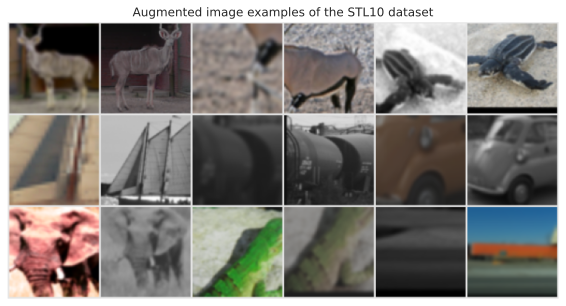

In [7]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 9
imgs = torch.stack(
    [img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0
)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the STL10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [8]:
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, (
            "The temperature must be a positive float!"
        )
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(
            num_classes=4 * hidden_dim
        )  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim),
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode="train"):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + "_loss", nll)
        # Get ranking position of positive example
        comb_sim = torch.cat(
            [
                cos_sim[pos_mask][:, None],  # First position positive example
                cos_sim.masked_fill(pos_mask, -9e15),
            ],
            dim=-1,
        )
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode="val")


# The validation step could be small simple downstream task like classification for the feat. ext. f(.) and
# track the performance of the base network on that task but here we validation with the contrastive loss
# and for testing we use classification on the STL10 test set

In [9]:
# Training
# For saving the best model checkpoint, we track the metric val_acc_top5, which is usually less noisy than val_acc_top1.


def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "SimCLR"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc_top5"),
            LearningRateMonitor("epoch"),
        ],
    )
    # Optional logging argument that we don't need
    trainer.logger._default_hp_metric = None

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SimCLR.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = SimCLR.load_from_checkpoint(pretrained_filename)
    else:
        train_loader = data.DataLoader(
            unlabeled_data,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        val_loader = data.DataLoader(
            train_data_contrast,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        pl.seed_everything(42)  # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        # Load best checkpoint after training
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

In [10]:
# Common observation in contrastive learning is that larger batch sizes means better model performance.
simclr_model = train_simclr(
    batch_size=256,
    hidden_dim=128,
    lr=5e-4,
    temperature=0.07,
    weight_decay=1e-4,
    max_epochs=500,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/contrastive_learn_simclr/SimCLR.ckpt`


Found pretrained model at saved_models/contrastive_learn_simclr/SimCLR.ckpt, loading...


In [ ]:
%tensorboard --logdir saved_models/contrastive_learn_simclr/tensorboards/SimCLR/

## Logistic Regression

After pretraining, we can use the feature extractor to extract features from the images for downstream tasks.
A common setup, which also verifies whether the model has learned generalized reprs, is to perform Logistic Regression on the features.
Or, learn a single, linear layer that maps the reprs to a class prediction.
Since the base network is unchanged during the log. regr training, the model can only perform well if the reprs describe all features necessary for the task. 
And, overfitting should not be an issue since we have very few parameters that are trained and the model should perform well even with very little data.

In [37]:
class LogisticRegression(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[
                int(self.hparams.max_epochs * 0.6),
                int(self.hparams.max_epochs * 0.8),
            ],
            gamma=0.1,
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [38]:
# Use the train and test STL10 sets
img_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_img_data = STL10(
    root=DATASET_PATH, split="train", download=True, transform=img_transforms
)
test_img_data = STL10(
    root=DATASET_PATH, split="test", download=True, transform=img_transforms
)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 5000
Number of test examples: 8000


In [39]:
# encode all images in the datasets using the prevously trained feat. ext. f(.)
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(
        dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False
    )
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

In [40]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

## Logistic regression training function 

In [41]:
def train_logreg(
    batch_size,
    train_feats_data,
    test_feats_data,
    model_suffix,
    max_epochs=100,
    **kwargs,
):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        enable_progress_bar=False,
        check_val_every_n_epoch=10,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(
        train_feats_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
        pin_memory=True,
        num_workers=0,
    )
    test_loader = data.DataLoader(
        test_feats_data,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        pin_memory=True,
        num_workers=0,
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(
        CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt"
    )
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

In [42]:
# Despite the training dataset of STL10 already only having 500 labeled images per class, we will perform experiments with even smaller datasets.
# Specifically, we train a Logistic Regression model for datasets with only 10, 20, 50, 100, 200, and all 500 examples per class


def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *[
            t.unflatten(0, (10, -1))[:, :num_imgs_per_label].flatten(0, 1)
            for t in original_dataset.tensors
        ]
    )
    return new_dataset

In [43]:
# train 6 models which will be done fast as we are not training the base feat. ext. model f(.) and just the log. reg. head
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_logreg(
        batch_size=64,
        train_feats_data=sub_train_set,
        test_feats_data=test_feats_simclr,
        model_suffix=num_imgs_per_label,
        feature_dim=train_feats_simclr.tensors[0].shape[1],
        num_classes=10,
        lr=1e-3,
        weight_decay=1e-3,
    )
    results[num_imgs_per_label] = small_set_results

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/contrastive_learn_simclr/LogisticRegression_10.ckpt`
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/user/Main/reference/ml_algo_implementations/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/user/Main/reference/ml_algo_implementations/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at saved_models/contrastive_learn_simclr/LogisticRegression_10.ckpt, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/contrastive_learn_simclr/LogisticRegression_20.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/contrastive_learn_simclr/LogisticRegression_50.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at saved_models/contrastive_learn_simclr/LogisticRegression_20.ckpt, loading...
Found pretrained model at saved_models/contrastive_learn_simclr/LogisticRegression_50.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/contrastive_learn_simclr/LogisticRegression_100.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/contrastive_learn_simclr/LogisticRegression_200.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at saved_models/contrastive_learn_simclr/LogisticRegression_100.ckpt, loading...
Found pretrained model at saved_models/contrastive_learn_simclr/LogisticRegression_200.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/contrastive_learn_simclr/LogisticRegression_500.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at saved_models/contrastive_learn_simclr/LogisticRegression_500.ckpt, loading...


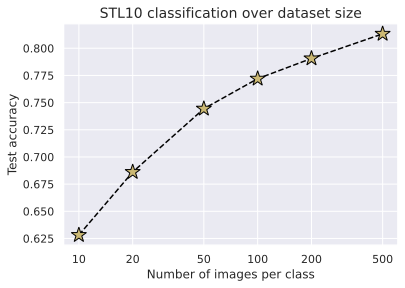

In [44]:
# visualiza results
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    dataset_sizes,
    test_scores,
    "--",
    color="#000",
    marker="*",
    markeredgecolor="#000",
    markerfacecolor="y",
    markersize=16,
)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

## Baseline

As a baseline to our results above, we will train a standard ResNet-18 with random initialization on the labeled training set of STL10. The results will give us an indication of the advantages that contrastive learning on unlabeled data has compared to using only supervised training.

In [45]:
class ResNet(pl.LightningModule):
    def __init__(self, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = torchvision.models.resnet18(num_classes=num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[
                int(self.hparams.max_epochs * 0.7),
                int(self.hparams.max_epochs * 0.9),
            ],
            gamma=0.1,
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

ResNet will easily overfit the data since its parameter count is more than 1000 times larger than the dataset size.
To make comparisons fair, we will similar data augmentations as in SimCLR case. Color distortions as before are not used because the color distribution of an image showed to be an important feature for the classification. Similarly, we restrict the resizing operation before cropping to the max. 125% of its original resolution, instead of 1250% as done in SimCLR. This is because, for classification, the model needs to recognize the full object, while in contrastive learning, we only want to check whether two patches belong to the same image/object.

In [46]:
train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_img_aug_data = STL10(
    root=DATASET_PATH, split="train", download=True, transform=train_transforms
)

Files already downloaded and verified


In [47]:
# The training function for the ResNet is almost identical to the Logistic Regression setup.
# Note that we allow the ResNet to perform validation every 2 epochs to also check whether the model overfits strongly in the first iterations or not.


def train_resnet(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        check_val_every_n_epoch=2,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(
        train_img_aug_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )
    test_loader = data.DataLoader(
        test_img_data,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = ResNet.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = ResNet(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = ResNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    val_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": val_result[0]["test_acc"]}

    return model, result

In [48]:
resnet_model, resnet_result = train_resnet(
    batch_size=64, num_classes=10, lr=1e-3, weight_decay=2e-4, max_epochs=100
)
print(f"Accuracy on training set: {100 * resnet_result['train']:4.2f}%")
print(f"Accuracy on test set: {100 * resnet_result['test']:4.2f}%")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/contrastive_learn_simclr/ResNet.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at saved_models/contrastive_learn_simclr/ResNet.ckpt, loading...


/home/user/Main/reference/ml_algo_implementations/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

Accuracy on training set: 99.78%
Accuracy on test set: 73.31%
